In [0]:
import numpy as np
import pandas as pd
import itertools as it
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# Librerias para el funcionamiento del algoritmo DBSCAN
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler




In [0]:
data = pd.read_csv("train.csv") 

In [0]:
Dy=data['price_range'].to_numpy()
Dx=data[['ram','battery_power']].to_numpy()

In [0]:
np.unique(Dy)
print(Dy)

[1 2 2 ... 3 0 3]


### Medidas de evaluación

In [0]:
def matriz_confusion(cat_real, cat_pred):
    cats = np.unique(cat_real)
    clusts = np.unique(cat_pred)
    mat = np.array([[np.sum(np.logical_and(cat_real==cats[i],cat_pred==clusts[j])) 
                     for j in np.arange(clusts.size)] 
                    for i in np.arange(cats.size)])
    return(mat)

def medida_error(mat):
    assign = np.sum([np.max(mat[l,:]) for l in np.arange(mat.shape[0])])
    return 1 - assign / float(np.sum(mat))

def medida_precision(mat, l, k):
    return mat[l,k]/(np.sum(mat[:,k]))

def medida_recall(mat, l, k):
    return mat[l,k]/(np.sum(mat[l,:]))

def medida_pureza(mat):
    totales = np.sum(mat,0)/float(np.sum(mat))
    return np.sum([(np.sum(mat[:,k])/np.sum(mat))
                   * np.max(mat[:,k]/float(np.sum(mat[:,k]))) for k in np.arange(mat.shape[1])])
def medida_f1_especifica(mat, l, k):
    prec = medida_precision(mat, l, k)
    rec = medida_recall(mat, l, k)
    if (prec+rec)==0:
        return 0
    else:
        return 2*prec*rec/(prec+rec)

def medida_f1(mat):
    totales = np.sum(mat,1)/float(np.sum(mat))
    assign = np.sum([totales[l] * np.max([medida_f1_especifica(mat, l, k) 
                                          for k in np.arange(mat.shape[1])]) 
                     for l in np.arange(mat.shape[0])])
    return assign

### Kmeans

Centros encontrados por...
el método programado
el método de Sci-kit Learn
[[3506.34392523 1270.77757009]
 [1543.07352941 1291.47689076]
 [ 669.345898   1219.44789357]
 [2483.55762082 1175.57063197]]
Matriz de confusión:
[[  0  94 405   1]
 [  0 315  46 139]
 [ 97  66   0 337]
 [439   0   0  61]]
El valor del error cometido es =  0.252
La pureza del agrupamiento obtenido es =  0.748
El valor F1 es =  0.7486762089053258


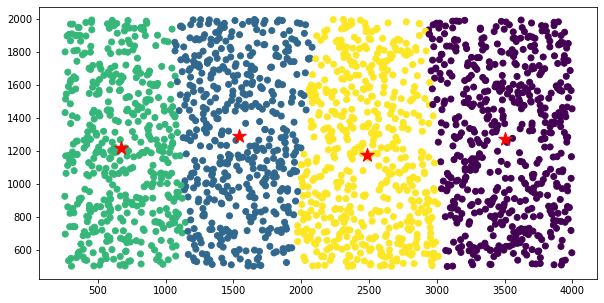

In [0]:
from sklearn.cluster import KMeans


# Se inicializa KMeans con el número de clústeres a buscar
modelo = KMeans(n_clusters=4)
# Se aprende el 
modelo = modelo.fit(Dx)
# Predicting the clusters
Dyp_sk = modelo.predict(Dx)
# Obtener los centros de los clústeres
cDx_sk = modelo.cluster_centers_

# Comparing with scikit-learn centroids
print("Centros encontrados por...")
print("el método programado")
#print(cDx)
print("el método de Sci-kit Learn")
print(cDx_sk)


mC_sk = matriz_confusion(Dy,Dyp_sk)

print('Matriz de confusión:')
print(mC_sk)
print('El valor del error cometido es = ', medida_error(mC_sk))
print('La pureza del agrupamiento obtenido es = ', medida_pureza(mC_sk))
print('El valor F1 es = ', medida_f1(mC_sk))

# Ver asignaciones finales
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp_sk)
ax.scatter(cDx_sk[:,0],cDx_sk[:,1], marker='*', s=200, c='r')


### Aglomerativo

Text(0, 0.5, 'Distancia euclideana')

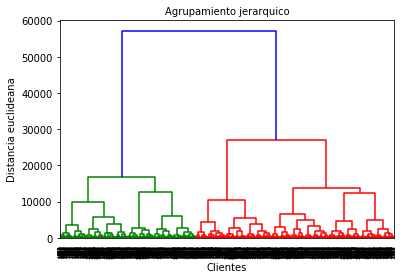

In [0]:
import scipy.cluster.hierarchy as sch
#Realizamos la gráfica a través del método de scipy llamado dendrograme. Como parametros le pasamos 
dendrogram = sch.dendrogram(sch.linkage(Dx, method = 'ward'))
plt.title('Agrupamiento jerarquico', fontsize = 10)
plt.xlabel('Clientes')
plt.ylabel('Distancia euclideana')


In [0]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward')

In [0]:
y_hc = hc.fit_predict(Dx)

No handles with labels found to put in legend.


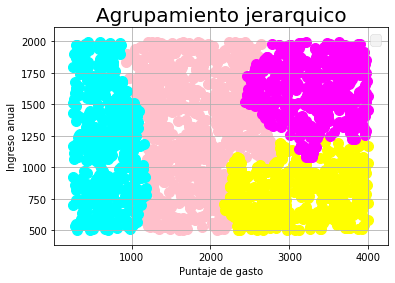

In [0]:
plt.scatter(Dx[y_hc == 0, 0], Dx[y_hc == 0, 1], s = 100, c = 'pink')
plt.scatter(Dx[y_hc == 1, 0], Dx[y_hc == 1, 1], s = 100, c = 'yellow')
plt.scatter(Dx[y_hc == 2, 0], Dx[y_hc == 2, 1], s = 100, c = 'cyan')
plt.scatter(Dx[y_hc == 3, 0], Dx[y_hc == 3, 1], s = 100, c = 'magenta')

plt.style.use('fivethirtyeight')
plt.title('Agrupamiento jerarquico', fontsize = 20)
plt.xlabel('Puntaje de gasto')
plt.ylabel('Ingreso anual')
plt.legend()
plt.grid()
plt.show()

## AGRUPAMIENTO ESPECTRAL

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.cluster import KMeans

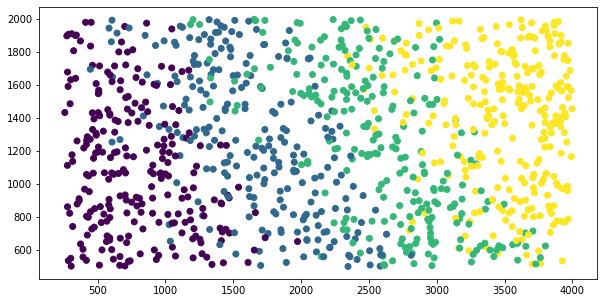

In [59]:
np.random.seed(17) # Fijamos una semilla para asegurar la reproducibilidad de la práctica

D = pd.read_csv("https://raw.githubusercontent.com/jignacioh/ActividadAprendizaNoSupervisado/master/telefonos_clasificacion/train.csv")
n = 1000
Dx = D[['ram','battery_power']].to_numpy()#D[:,:2]
Dx = Dx[:n]

Dy = D['price_range'].to_numpy()#D[:,2]
Dy = Dy[:n]

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0], Dx[:,1], c = Dy)

In [0]:
from sklearn.cluster import SpectralClustering
K = 4
knn = 10

# Inicializacion del modelo  SpectralClustering y entrenamiento usando matriz laplaciana normalizada y matriz de afinidad completa
clustering_spectral = SpectralClustering(n_clusters = K, 
                                affinity = 'nearest_neighbors', n_neighbors = knn,
                                random_state = 0).fit(Dx)

In [0]:
# Obtencion de valores predichos
Dy_espectral = clustering_spectral.labels_

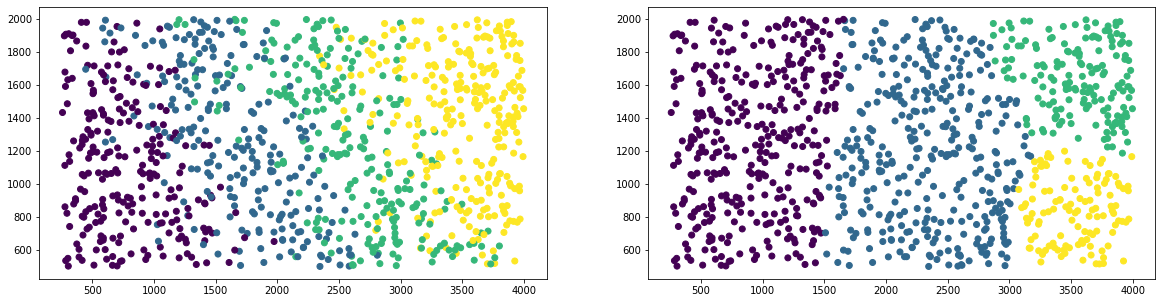

In [62]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
# clustering original
ax[0].scatter(Dx[:,0], Dx[:,1], c = Dy)
# clustering spectral
ax[1].scatter(Dx[:,0], Dx[:,1], c=Dy_espectral)

### DBSCAN

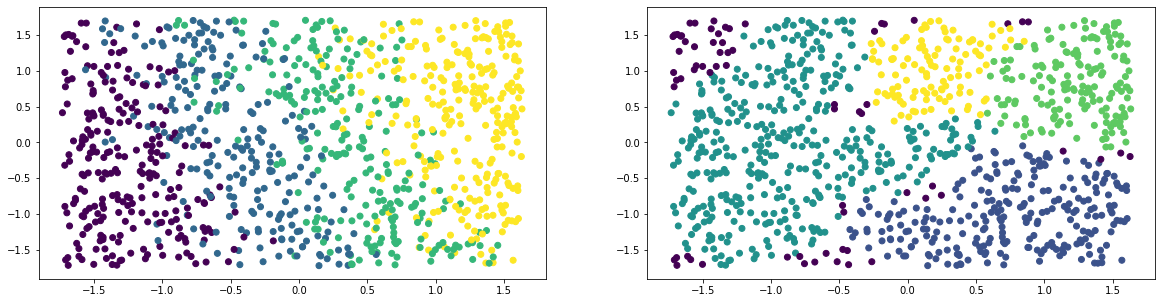

In [0]:
np.random.seed(17) # Fijamos una semilla para asegurar la reproducibilidad de la práctica

D = pd.read_csv("https://raw.githubusercontent.com/jignacioh/ActividadAprendizaNoSupervisado/master/telefonos_clasificacion/train.csv")
n = 1000
Dx = D[['ram','battery_power']].to_numpy()#D[:,:2]
Dx = Dx[:n]

Dy = D['price_range'].to_numpy()#D[:,2]
Dy = Dy[:n]


eps = 0.327
M = 30
mDistancia = euclidean_distances(Dx)
Dx = StandardScaler().fit_transform(Dx)


Dyp = DBSCAN(eps=eps, min_samples=M).fit(Dx)#agrupamiento_densidad_DBSCAN(mDistancia,eps,M)


fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].scatter(Dx[:,0], Dx[:,1], c = Dy)
ax[1].scatter(Dx[:,0], Dx[:,1], c = Dyp.labels_)
plt.show()
# Agregar Espectral
# Probabilistico




### Probabilistico

El dataset cargado tiene 2000 instancias.


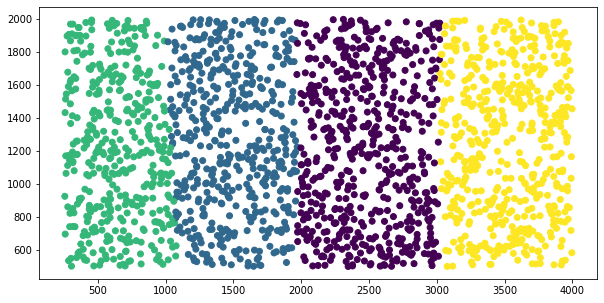

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture



def matriz_confusion(cat_real, cat_pred):
    cats = np.unique(cat_real)
    clusts = np.unique(cat_pred)
    mat = np.array([[np.sum(np.logical_and(cat_real==cats[i], cat_pred==clusts[j]))
                     for j in np.arange(clusts.size)]
                    for i in np.arange(cats.size)])
    return(mat)


#data_file_url = "train.csv"# 'https://raw.githubusercontent.com/javier-sevilla/ANS/master/datasets/sinteticos/dataset_cuatro_diferente_medida.csv'
D = pd.read_csv("train.csv")#np.array(pd.read_csv(data_file_url,header=0))
#D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[['ram','battery_power']].to_numpy()#D[:,0:2]
Dy =  D['price_range'].to_numpy()#D[:,2]
print('El dataset cargado tiene',Dy.size,'instancias.')


# Se inicializa el método con el número de clústeres (componentes) a buscar
modelo = GaussianMixture(n_components = 4, max_iter = 200)
# Se aprende el modelo
modelo = modelo.fit(Dx)
# Se predicen las asignaciones a clústeres
Dyp_sk = modelo.predict(Dx)

# Medimos el rendimiento del algoritmo de ScikitLearn
mC_sk = matriz_confusion(Dy,Dyp_sk)


#print('Matriz de confusión:')
#print(mC_sk)
#print('El valor del error cometido es = ', medida_error(mC_sk))
#print('La pureza del agrupamiento obtenido es = ', medida_pureza(mC_sk))
#print('El valor F1 es = ', medida_f1(mC_sk))

# Ver asignaciones finales
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp_sk)
plt.show()